In [1]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import pywt
from sklearn.mixture import GaussianMixture

In [2]:
def energy_weighted_group_delay(signal):
    
    R = int(0.0025*sr_egg)
    group_delay = np.zeros((len(signal) - R + 1, R))
    mult = np.arange(R)
    
    for i in range(len(signal) - R + 1):
        X = np.fft.fft(signal[i:i+R])
        X_r = np.fft.fft(signal[i:i+R]*mult)
        group_delay[i] = np.real(X_r/X)

    ewgd = np.zeros(len(signal) - R + 1)
    
    for i in range(len(signal) - R + 1):
        X_sq = np.square(np.abs(np.fft.fft(signal[i:i+R])))
        ewgd[i] = np.sum(X_sq*group_delay[i])/np.sum(X_sq)
        
    ewgd -= (R - 1)/2.
    
    return ewgd

In [3]:
def zero_crossing_pos2neg(signal):
    rectified = signal > 0
    return np.where(np.logical_and(np.logical_xor(rectified[:-1],rectified[1:]),rectified[:-1]))[0]

In [4]:
def get_cluster(zc_pos2neg,ewgd,p_positive):
    feature_mat = np.zeros((len(zc_pos2neg),3))

    ideal = np.arange(27,-28,-1)

    R = int(0.0025*sr_egg)
        
    for i in range(len(zc_pos2neg)):
        ewgd_window = ewgd[zc_pos2neg[i] - int((R-1)/2):zc_pos2neg[i] + int((R-1)/2) + 1]
        feature_mat[i,0] = np.sqrt(np.mean(np.square(ewgd_window - ideal)))
        p_pos_window = p_positive[zc_pos2neg[i] - int((R-1)/2):zc_pos2neg[i] + int((R-1)/2) + 1]
        feature_mat[i,1] = np.amax(p_pos_window**(1/3.))
        feature_mat[i,2] = np.sum(p_pos_window**(1/3.))
        
    gmm = GaussianMixture(n_components=2)
    gmm.fit(feature_mat)
    label = gmm.predict(feature_mat)
    
    if np.mean(feature_mat[label == 1,2]) > np.mean(feature_mat[label == 0,2]):
        return zc_pos2neg[label == 1]
    return zc_pos2neg[label == 0]

In [5]:
def swallowing(gci):
    N_max = 0.02 * sr_egg
    diff = gci[1:] - gci[:-1]
    keep = np.zeros(len(gci))
    remove = diff>N_max
    keep[:-1] += remove
    keep[1:] += remove
    return gci[keep == 0]

In [6]:
def goi_post_processing(goi_candidates,gci):
    goi = []
    N_max = 0.02 * sr_egg
    for i in range(len(gci)-1):
        if gci[i+1] - gci[i] < N_max:
            check = 0
            for j in range(gci[i] + int((gci[i+1]-gci[i])*0.1),gci[i] + int((gci[i+1]-gci[i])*0.9)):
                if j in goi_candidates:
                    goi.append(j)
                    check = 1
                    break
            if check == 0:
                goi.append(gci[i] + int((gci[i+1]-gci[i])*0.5))
    return goi     

In [7]:
def get_glottal(egg):
    
    swt = pywt.swt(egg, wavelet = "bior1.5", level = 3)
    multiscale_product = swt[0][1]*swt[1][1]*swt[2][1]
    
    p_positive = multiscale_product*(multiscale_product>0)
    p_negative = multiscale_product*(multiscale_product<0)
    
    ewgd_gci = energy_weighted_group_delay(p_positive)
    ewgd_gci[np.where(np.isnan(ewgd_gci))] = 0
    
    ewgd_goi = energy_weighted_group_delay(-p_negative)
    ewgd_goi[np.where(np.isnan(ewgd_goi))] = 0
    
    zc_pos2neg_gci = zero_crossing_pos2neg(ewgd_gci)
    zc_pos2neg_goi = zero_crossing_pos2neg(ewgd_goi)
    
    R = int(0.0025*sr_egg)

    for i in range(len(zc_pos2neg_gci)):
        if zc_pos2neg_gci[i] > int((R-1)/2):
            zc_pos2neg_gci = zc_pos2neg_gci[i:]
            break
            
    for i in range(len(zc_pos2neg_goi)):
        if zc_pos2neg_goi[i] > int((R-1)/2):
            zc_pos2neg_goi = zc_pos2neg_goi[i:]
            break
            
    cluster_gci = get_cluster(zc_pos2neg_gci,ewgd_gci,p_positive)
    cluster_goi = get_cluster(zc_pos2neg_goi,ewgd_goi,-p_negative)
    
    gci = swallowing(cluster_gci)
    
    goi = goi_post_processing(cluster_goi,gci)
    
    return gci,goi

In [8]:
egg_location = r"C:\Users\user\Desktop\egg.wav"
speech_location = r"C:\Users\user\Desktop\speech.wav"

egg, sr_egg = librosa.load(egg_location)
speech, _ = librosa.load(speech_location)

if len(egg)%8 != 0:
    egg = egg[:-(len(egg)%8)]
    speech = speech[:-(len(speech)%8)]

In [9]:
gci,goi =  get_glottal(egg)

C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [28]:
def plot(egg,speech,gci,goi):
    window_start = 0
    window_length = 77943
    
    gci_plot = np.zeros(len(egg))
    goi_plot = np.zeros(len(egg))

    gci_plot[gci] = 1
    goi_plot[goi] = 1
    
    plt.plot(speech[window_start:window_start+window_length])
    plt.title('speech signal')
    plt.show()
    plt.plot(egg[window_start:window_start+window_length])
    plt.title('EGG')
    plt.show()
    plt.plot(egg[window_start+1:window_start+window_length+1] - egg[window_start:window_start+window_length])
    plt.title('dEGG')
    plt.show()
    plt.plot(gci_plot[window_start:window_start+window_length],label='gci')
    plt.plot(goi_plot[window_start:window_start+window_length],label='goi')
    plt.title('glottal instants')
    plt.legend()
    plt.show()

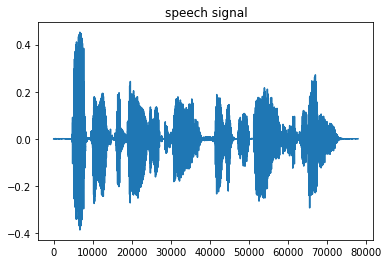

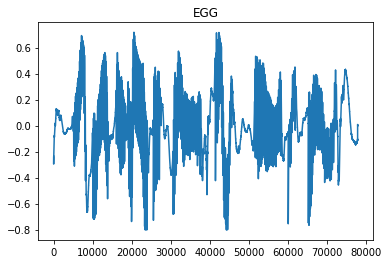

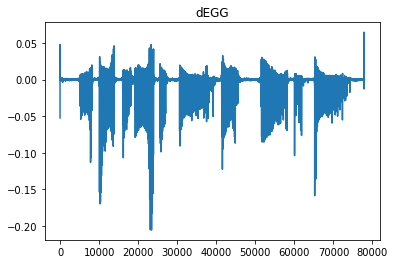

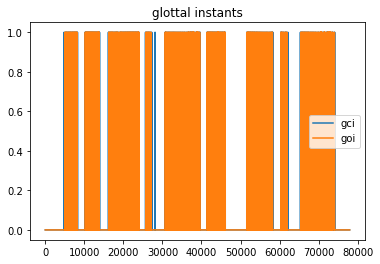

In [29]:
plot(egg, speech, gci, goi)